In [1]:
"""
Model to train protein sequences of len btw 0-300 and samples size 1k-10k
"""
import sys, random , re, os
from pathlib import Path
import pandas as pd
from tqdm import tqdm

import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

ProjectRoot = Path('/home/satish27may/ProteinDomainDetection/')
print(f"ProjectRoot: {ProjectRoot}")
sys.path.append(str(ProjectRoot))

from src.data.modelData import ObjectDetection, create_protein_seq_image


/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


ProjectRoot: /home/satish27may/ProteinDomainDetection


In [2]:
# create bucket data
seq_len_bucket = (0, 300)
num_sample_bucket = (1000,10000)
img_h, img_w = 224, seq_len_bucket[1]
config_name = f"seq_len_{seq_len_bucket[0]}-{seq_len_bucket[1]}_and_num_samples_{num_sample_bucket[0]}-{num_sample_bucket[1]}"

# os.system(f"trash-put {str(ProjectRoot/f'data/PfamData/{config_name}_images')}")
os.system(f"trash-put {str(ProjectRoot/f'models/{config_name}_model')}")

# create model dir to save checkpoints
all_models_dir = ProjectRoot/'models'
if not all_models_dir.exists():
    all_models_dir.mkdir(exist_ok=True, parents=True)
model_dir = ProjectRoot/f'models/{config_name}_model'
model_dir.mkdir(exist_ok=True, parents=True)

# # log to log file
# log_file = model_dir/'logs.txt'
# sys.stdout = open(str(log_file), 'w')
    
# create all classes data from pfam fasta data
all_classes = ['Lysozyme-PF03245',
'Lysozyme-PF16754',
'Lysozyme-PF11860',
'Lysozyme-PF13702',
'Lysozyme-PF00959',
'Lysozyme-PF00182',
'Lysozyme-PF00704',
'Lysozyme-PF01374',
'Lysozyme-PF05838',
'Lysozyme-PF18013',
'Lysozyme-PF04965',
'Lysozyme-PF01183',
'Lysozyme-PF00722',
'peptidase-PF05193',
'peptidase-PF01551',
'peptidase-PF00675',
'peptidase-PF01435',
'peptidase-PF01433',
'peptidase-PF10502',
'peptidase-PF00246',
'peptidase-PF03572',
'peptidase-PF00814',
'peptidase-PF17900',
'Amidase_2-PF01510',
'Amidase_3-PF01520',
'CHAP-PF05257',
'SH3_4-PF06347',
'SH3_3-PF08239',
'SH3_5-PF08460',
'LysM-PF01476']
data_handler = ObjectDetection(class_names=all_classes)
protein_domain_data = data_handler.create_protein_domain_df()

# create data df for choosen config
bucket_df = data_handler.get_bucketised_data(protein_domain_data, seq_len_bucket, num_sample_bucket)
class_freq_map = dict(bucket_df['Class'].value_counts())
classes = [cls for cls in list(bucket_df['Class'].unique()) if class_freq_map[cls]>50]
bucket_df = bucket_df[bucket_df['Class'].isin(classes)]
# select sub set classes !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
bucket_df = bucket_df[bucket_df['Class'].isin(['PF08239', 'PF06347', 'PF00246', 'PF01510'])]
classes= list(bucket_df['Class'].unique() )
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
bucket_df.to_csv(ProjectRoot/f"data/PfamData/seq_len_{'-'.join([str(x) for x in seq_len_bucket])}_and_num_samples_{'-'.join([str(x) for x in num_sample_bucket])}_data.csv",index=False)


# create image data for choosen config
data_handler.create_bucket_sequence2histogram(bucket_df, seq_len_bucket, num_sample_bucket)

# print config data summary
images_dir = ProjectRoot/f"data/PfamData/{config_name}_images"
model_data =  pd.read_csv(ProjectRoot/f"data/PfamData/{config_name}_data.csv")
print(f"Selected {model_data['Class'].nunique()} classes:\n{model_data['Class'].unique()}")



Dropped 2663 number of duplicates based on sequences
Fetching data with sequence len in btw (0, 300) and class with num samples btw (1000, 10000)
Bucket class distribution: PF01551    9121
PF01435    7878
PF01510    6831
PF00814    6775
PF00722    6269
PF08239    4598
PF01520    4174
PF04965    3157
PF01183    3060
PF00959    2279
PF00704    2076
PF00182    1874
PF05257    1638
PF06347    1388
PF00246    1355
PF05838    1095
Name: Class, dtype: int64
  Sequences lens: min=26, max = 299
Genreating  images of dim 224x300 data bucket with sequence len in btw (0, 300) and class with num samples btw (1000, 10000)
Selected 4 classes:
['PF08239' 'PF01510' 'PF00246' 'PF06347']


In [3]:
###############################################Create Model Data##############################################################################
def create_train_valid_test_data(data_df):
    train_dfs,valid_dfs = [],[],
    for class_name in data_df['Class'].unique():
        class_df = data_df[data_df['Class']==class_name].sample(frac=1)
        num_samples = class_df.shape[0]
        num_train_samples = int(round(num_samples*0.7))
        train_dfs.append(class_df.iloc[:num_train_samples,:])
        valid_dfs.append(class_df.iloc[num_train_samples:,:])
    return pd.concat(train_dfs,axis='rows').sample(frac=1), pd.concat(valid_dfs,axis='rows').sample(frac=1)
    
def create_dataset(model_data, img_h, img_w, mode, classes, aug_data):
    model_data = model_data[model_data['Class'].isin([x.split('-')[-1] for x in classes])]
    print(f"Classes selected: {model_data['Class'].unique()}")
    print(f"SuperClasses selected: {model_data['SuperClass'].unique()}")
    model_data = model_data.reset_index(drop=True)
    model_data['dom_pos'] = model_data['dom_pos'].apply(lambda x: [int(y) for y in x.replace('[','').replace(']','').split(',')])
    C2I = {class_name:index for index, class_name in enumerate(model_data['Class'].unique())}
    train_dicts_list = []
    valid_dicts_list = []
    train, valid = create_train_valid_test_data(model_data)
    train = train.reset_index(drop=True)
    valid = valid.reset_index(drop=True)
    if mode=='train':
        for index in tqdm(range(train.shape[0])):
            x1,x2 = train['dom_pos'][index]
            train_dicts_list.append({'file_name':train['img_pth'][index],
                               'height':img_h,
                               'width': img_w,
                               'image_id': index,
                               'annotations':[{'bbox':[x1, 0, x2, img_h],
                                               'bbox_mode':BoxMode.XYXY_ABS,
                                               'category_id':  C2I[train['Class'][index]],
                                              }]
                              })
    if mode=='valid':
        for index in tqdm(range(valid.shape[0])):
            x1,x2 = valid['dom_pos'][index]
            valid_dicts_list.append({'file_name':valid['img_pth'][index],
                               'height':img_h,
                               'width': img_w,
                               'image_id': index,
                               'annotations':[{'bbox':[x1, 0, x2, img_h],
                                               'bbox_mode':BoxMode.XYXY_ABS,
                                               'category_id':  C2I[valid['Class'][index]],
                                              }]
                              })
    if mode=='train':return train_dicts_list
    elif mode=='valid': return valid_dicts_list

# create train and valid data
train_list = create_dataset(model_data, img_h=img_h, img_w=img_w, mode='train', classes=classes, aug_data=False)
valid_list = create_dataset(model_data, img_h=img_h, img_w=img_w, mode='valid', classes=classes, aug_data=False)
def get_train_data():
    return train_list

def get_valid_data():
    return valid_list


# add custom dataset to detectron 2 pipline
DatasetCatalog.register("train", get_train_data)
DatasetCatalog.register("valid", get_valid_data)

train_meta_data = MetadataCatalog.get("train").set(thing_classes = classes)
valid_meta_data = MetadataCatalog.get("valid").set(thing_classes = classes)

Classes selected: ['PF08239' 'PF01510' 'PF00246' 'PF06347']
SuperClasses selected: ['SH3_3' 'Amidase_2' 'peptidase' 'SH3_4']


  0%|          | 0/4251 [00:00<?, ?it/s]

Classes selected: ['PF08239' 'PF01510' 'PF00246' 'PF06347']
SuperClasses selected: ['SH3_3' 'Amidase_2' 'peptidase' 'SH3_4']


100%|██████████| 4251/4251 [00:00<00:00, 10590.10it/s]


{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/None_images/img_E0SMW1_DICD3_PF01510_Amidase_2.png', 'height': 224, 'width': 300, 'image_id': 4722, 'annotations': [{'bbox': [43, 0, 183, 224], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1}]}


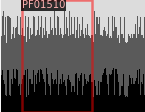

{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/None_images/img_A0A1V2GTE2_9PROT_PF06347_SH3_4.png', 'height': 224, 'width': 300, 'image_id': 5293, 'annotations': [{'bbox': [94, 0, 144, 224], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3}]}


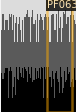

{'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/None_images/img_I4ZC34_9BACT_PF01510_Amidase_2.png', 'height': 224, 'width': 300, 'image_id': 9743, 'annotations': [{'bbox': [0, 0, 140, 224], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1}]}


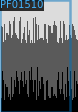

In [5]:
for d in random.sample(train_list, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_meta_data, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [4]:
!trash-put /home/satish27may/ProteinDomainDetection/models/seq_len_0-300_and_num_samples_1000-10000_model

In [ ]:
%load_ext autoreload
%autoreload 2

In [6]:
##############################################################################################################################################
# train model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("valid",)
#cfg.MODEL.PIXEL_MEAN = data_mean
#cfg.MODEL.PIXEL_STD = data_std
cfg.INPUT.RANDOM_FLIP = "vertical"
cfg.TEST.DETECTIONS_PER_IMAGE = 100

cfg.INPUT.MIN_SIZE_TRAIN = (img_h,)
cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
# Maximum size of the side of the image during training
cfg.INPUT.MAX_SIZE_TRAIN = img_w
# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
cfg.INPUT.MIN_SIZE_TEST = img_h
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = img_w


cfg.TEST.AUG.FLIP = False
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
# cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.RETINANET.NUM_CLASSES = len(classes)


# exp configs
# cfg.MODEL.FPN.IN_FEATURES = ["res3", "res4", "res5"] didint work


cfg.OUTPUT_DIR =str(model_dir)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# evaluate model
evaluator = COCOEvaluator("valid", ("bbox",), False, output_dir=cfg.OUTPUT_DIR )
val_loader = build_detection_test_loader(cfg, "valid")

Loading config /home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[12/06 05:18:30 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (36, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.


[12/06 05:18:34 d2.engine.train_loop]: Starting training from iteration 0
ERROR [12/06 05:18:35 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 134, in train
    self.run_step()
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/engine/defaults.py", line 423, in run_step
    self._trainer.run_step()
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 222, in run_step
    data = next(self._data_loader_iter)
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/data/common.py", line 179, in __iter__
    for d in self.dataset:
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 435, in __next__
    data = self._next_data()
  File

SizeMismatchError: Caught SizeMismatchError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/data/common.py", line 43, in __getitem__
    data = self._map_func(self._dataset[cur_idx])
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/utils/serialize.py", line 23, in __call__
    return self._obj(*args, **kwargs)
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/data/dataset_mapper.py", line 126, in __call__
    utils.check_image_size(dataset_dict, image)
  File "/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/data/detection_utils.py", line 200, in check_image_size
    expected_wh,
detectron2.data.detection_utils.SizeMismatchError: Mismatched (W,H) for image /home/satish27may/ProteinDomainDetection/data/PfamData/None_images/img_X7F613_9RHOB_PF08239_SH3_3.png, got (220, 224), expect (300, 224)


In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("valid", ("bbox",), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "valid")
print(trainer.test(cfg, trainer.model, evaluator))

[12/05 09:18:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(224, 224), max_size=300, sample_style='choice')]
[12/05 09:18:09 d2.data.common]: Serializing 4251 elements to byte tensors and concatenating them all ...
[12/05 09:18:09 d2.data.common]: Serialized dataset takes 1.17 MiB
[12/05 09:18:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(224, 224), max_size=300, sample_style='choice')]
[12/05 09:18:10 d2.data.common]: Serializing 4251 elements to byte tensors and concatenating them all ...
[12/05 09:18:10 d2.data.common]: Serialized dataset takes 1.17 MiB
[12/05 09:18:10 d2.evaluation.evaluator]: Start inference on 4251 images
[12/05 09:18:11 d2.evaluation.evaluator]: Inference done 11/4251. 0.0634 s / img. ETA=0:04:34
[12/05 09:18:16 d2.evaluation.evaluator]: Inference done 96/4251. 0.0581 s / img. ETA=0:04:06
[12/05 09:18:21 d2.evaluation.evaluat

In [ ]:
len(set(bucket_df[bucket_df['Class']=='PF06347']['Sequence']))